In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
file_path = r"C:\Users\wagne\OneDrive\Documents\01_Etudes\03_ETHZ\05_MA3\01_Strassenverkehrssicherheit\Projekt\2025_Vorlesung-SVS_Hausarbeit_Daten\2025_Vorlesung-SVS_Hausarbeit_Daten\svu14-23.csv"

# Try reading with a more compatible encoding and automatic delimiter detection
df = pd.read_csv(file_path, encoding='latin1', delimiter=',')

In [3]:
df.columns.tolist()

['UnfallUID',
 'EreignisOID',
 'Quelle',
 'Unfalljahr',
 'Unfalldatum',
 'Unfallzeit',
 'Unfallmonat',
 'Feiertag',
 'Unfallkanton',
 'EreignisTotalBeteiligte',
 'EreignisTotalObjekte',
 'EreignisTotalPersonen',
 'Unfalltypengruppe',
 'Unfalltyp',
 'Sachschaden',
 'Hauptursachengruppe',
 'Hauptursachenuntergruppe',
 'Hauptursache',
 'InnerortsAusserorts',
 'Ortslage',
 'xKoordinate',
 'yKoordinate',
 'Autobahnname',
 'Gemeindenummer',
 'GemeindeText',
 'Ortschaft',
 'Strassenart',
 'StrassenartZusatz_1',
 'StrassenartZusatz_2',
 'StrassenartZusatz_3',
 'Strassenkategorie',
 'Zonensignalisation',
 'Höchstgeschwindigkeit',
 'HöchstgeschwindigkeitZusatz_1',
 'HöchstgeschwindigkeitZusatz_2',
 'Unfallstelle',
 'UnfallstelleZusatz_1',
 'UnfallstelleZusatz_2',
 'UnfallstelleZusatz_3',
 'UnfallstelleZusatz_4',
 'UnfallstelleZusatz_5',
 'UnfallstelleZusatz_6',
 'Vortrittsregelung',
 'VortrittsregelungZusatz_1',
 'VortrittsregelungZusatz_2',
 'Verkehrsaufkommen',
 'Witterung',
 'Witterungzusatz_

In [4]:
columns_to_keep = [
    'UnfallUID', 'Unfalljahr', 'Alter', 'Geschlecht',
    'Verkehrsteilnahme', 'Verkehrsteilnahme_d', 'Personenart',
    'Hauptursachengruppe', 'Hauptursache',
    'InnerortsAusserorts', 'Ortslage', 'Witterung', 'Lichtverhältnis', 'Unfallfolgen',
    'Fahrzeugart', 'Hauptverursacher'
]
df_small = df[columns_to_keep]

## 1. Eltere Fussgänger/innen

In [5]:
df_1 = df_small[df_small['Personenart'] == "Fussgänger/in"]

In [6]:
df_1['Alter'] = pd.to_numeric(df_small['Alter'], errors='coerce')

C:\Users\wagne\AppData\Local\Temp\ipykernel_12612\3786379947.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['Alter'] = pd.to_numeric(df_small['Alter'], errors='coerce')


In [7]:
df_1 = df_1[df_1['Alter'].notna()] ## filter out NaN values for age

In [8]:
total_rows = len(df_1)
print("Total rows:", total_rows)
elderly_rows = len(df_1[df_1['Alter'] > 64])
print("Rows with Alter ≥ 65:", elderly_rows)
percentage_elderly = elderly_rows / total_rows * 100
print(f"Percentage of elderly (≥65): {percentage_elderly:.2f}%")

Total rows: 22715
Rows with Alter ≥ 65: 4903
Percentage of elderly (≥65): 21.58%


In [9]:
df_1['senior'] = (df_1['Alter'] >= 65).astype(int)

In [10]:
elderly_by_year = df_1.groupby('Unfalljahr')['senior'].agg(
    total='count',        # total number of pedestrians with known age
    elderly='sum'         # number of elderly pedestrians
).reset_index()

In [11]:
bins = [0, 20, 65, 80, np.inf]
labels = ["0-19", "20-64", "65-79", "80+"]

In [12]:
df_1['age_bin'] = pd.cut(df_1['Alter'], bins=bins, labels=labels, right=False)

# Compute accident counts per bin
age_counts = df_1['age_bin'].value_counts().sort_index()

# Convert to percentage of total pedestrian accidents
age_percent = age_counts / age_counts.sum() * 100

# Population reference percentages
population_ref = pd.Series({
    "0-19": 19.9,
    "20-64": 60.6,
    "65-79": 13.8,
    "80+": 5.8
})

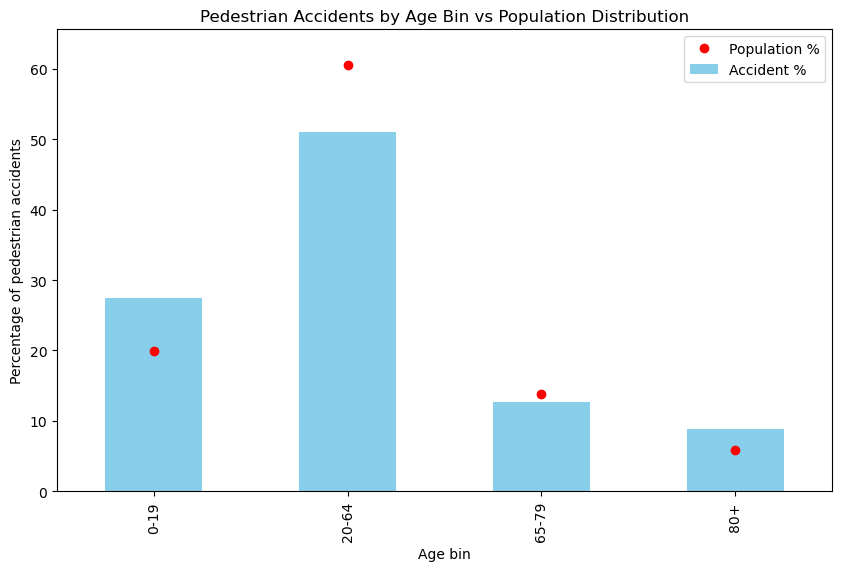

In [13]:
plt.figure(figsize=(10,6))
age_percent.plot(kind='bar', color='skyblue', label='Accident %')
plt.ylabel('Percentage of pedestrian accidents')
plt.xlabel('Age bin')
plt.title('Pedestrian Accidents by Age Bin vs Population Distribution')

# Overlay population reference points
for i, label in enumerate(labels):
    plt.plot(i, population_ref[label], 'ro', label='Population %' if i==0 else "")  # only show label once

plt.ylim(0, max(max(age_percent), max(population_ref))+5)
plt.legend()
plt.show()

In [14]:
unique_injuries = df_1['Unfallfolgen'].dropna().unique()
print(unique_injuries)

['nicht verletzt' 'leicht verletzt' 'schwer verletzt (vor 2015)'
 'innert 30 Tagen gestorben' 'unbekannt' 'auf Platz gestorben'
 'erheblich verletzt' 'lebensbedrohlich verletzt']


In [15]:
bins = [0, 20, 65, 80, np.inf]
labels = ["0-19", "20-64", "65-79", "80+"]
df_1['age_bin'] = pd.cut(df_1['Alter'], bins=bins, labels=labels, right=False)

In [16]:
population_ref = pd.Series({
    "0-19": 19.9,
    "20-64": 60.6,
    "65-79": 13.8,
    "80+": 5.8
})

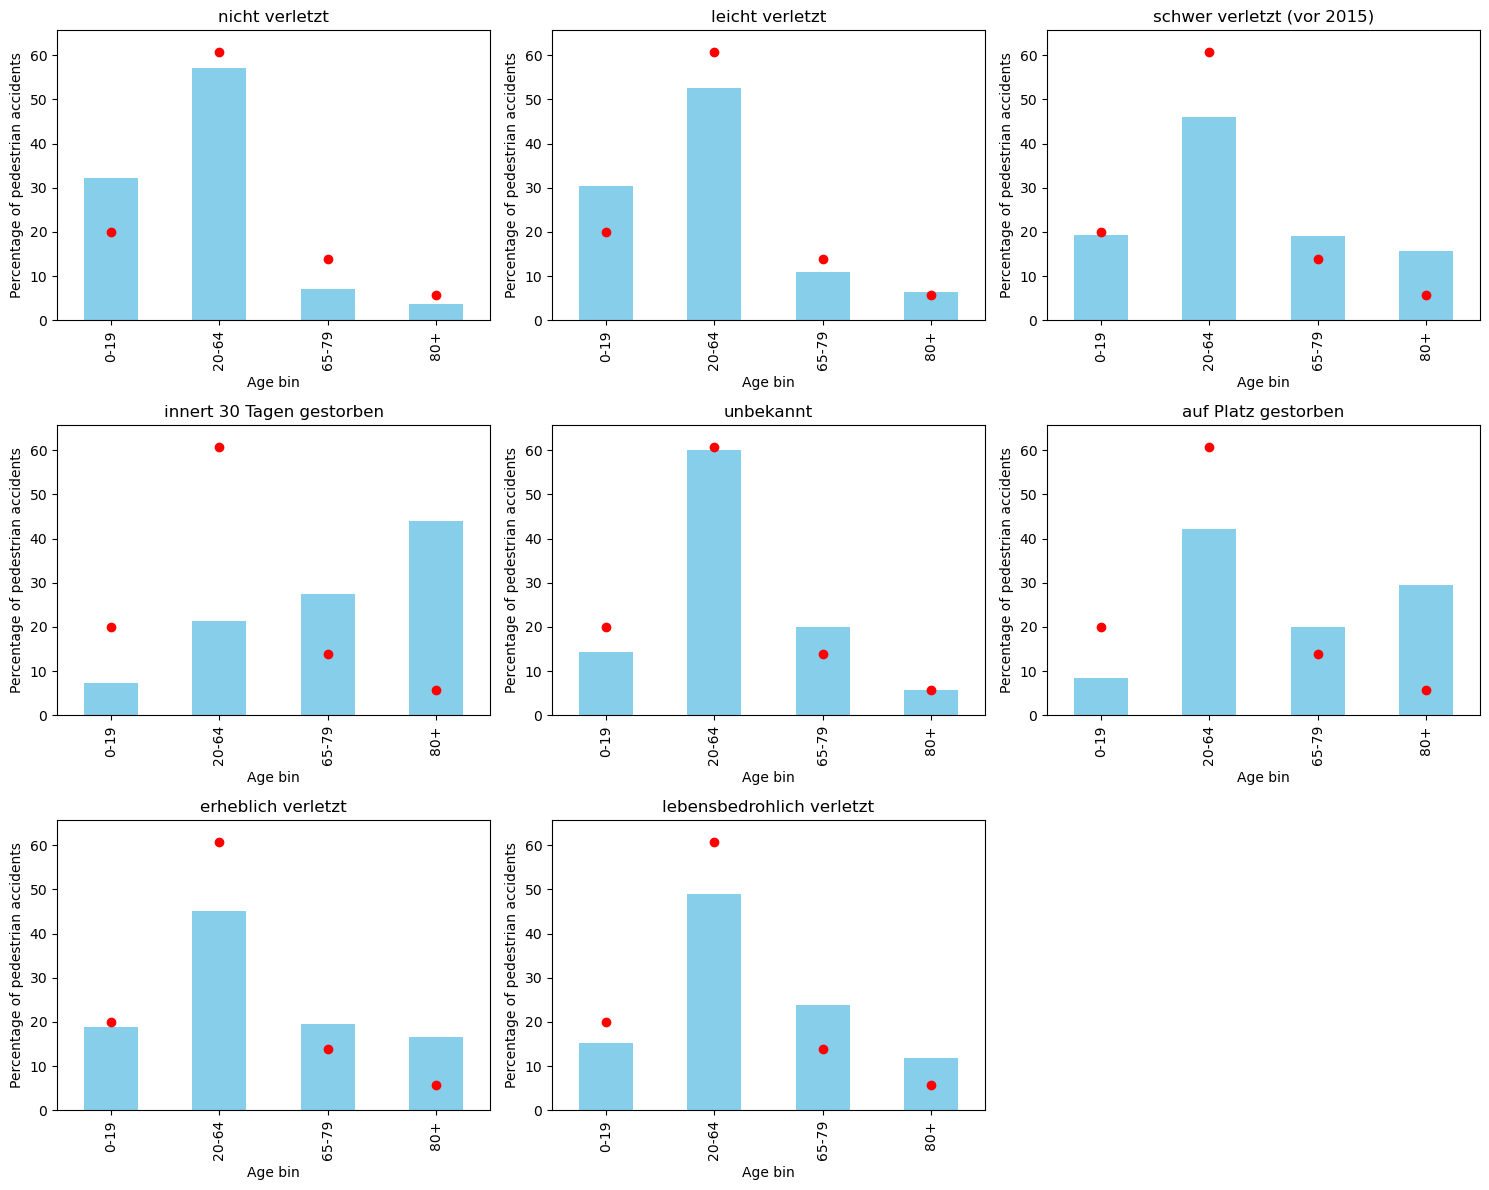

In [17]:
n_cols = 3
n_rows = math.ceil(len(unique_injuries) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows), squeeze=False)

for idx, injury in enumerate(unique_injuries):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row, col]
    
    df_subset = df_1[df_1['Unfallfolgen'] == injury]
    age_counts = df_subset['age_bin'].value_counts().sort_index()
    age_percent = age_counts / age_counts.sum() * 100
    
    # Bar plot
    age_percent.plot(kind='bar', color='skyblue', ax=ax)
    
    # Overlay population reference
    for i, label in enumerate(labels):
        ax.plot(i, population_ref[label], 'ro', label='Population %' if i==0 else "")
    
    ax.set_title(f'{injury}')
    ax.set_xlabel('Age bin')
    ax.set_ylabel('Percentage of pedestrian accidents')
    ax.set_ylim(0, max(max(age_percent), max(population_ref)) + 5)
    
# Remove empty subplots if any
total_subplots = n_rows * n_cols
for idx in range(len(unique_injuries), total_subplots):
    fig.delaxes(axes.flatten()[idx])

plt.tight_layout()
plt.show()

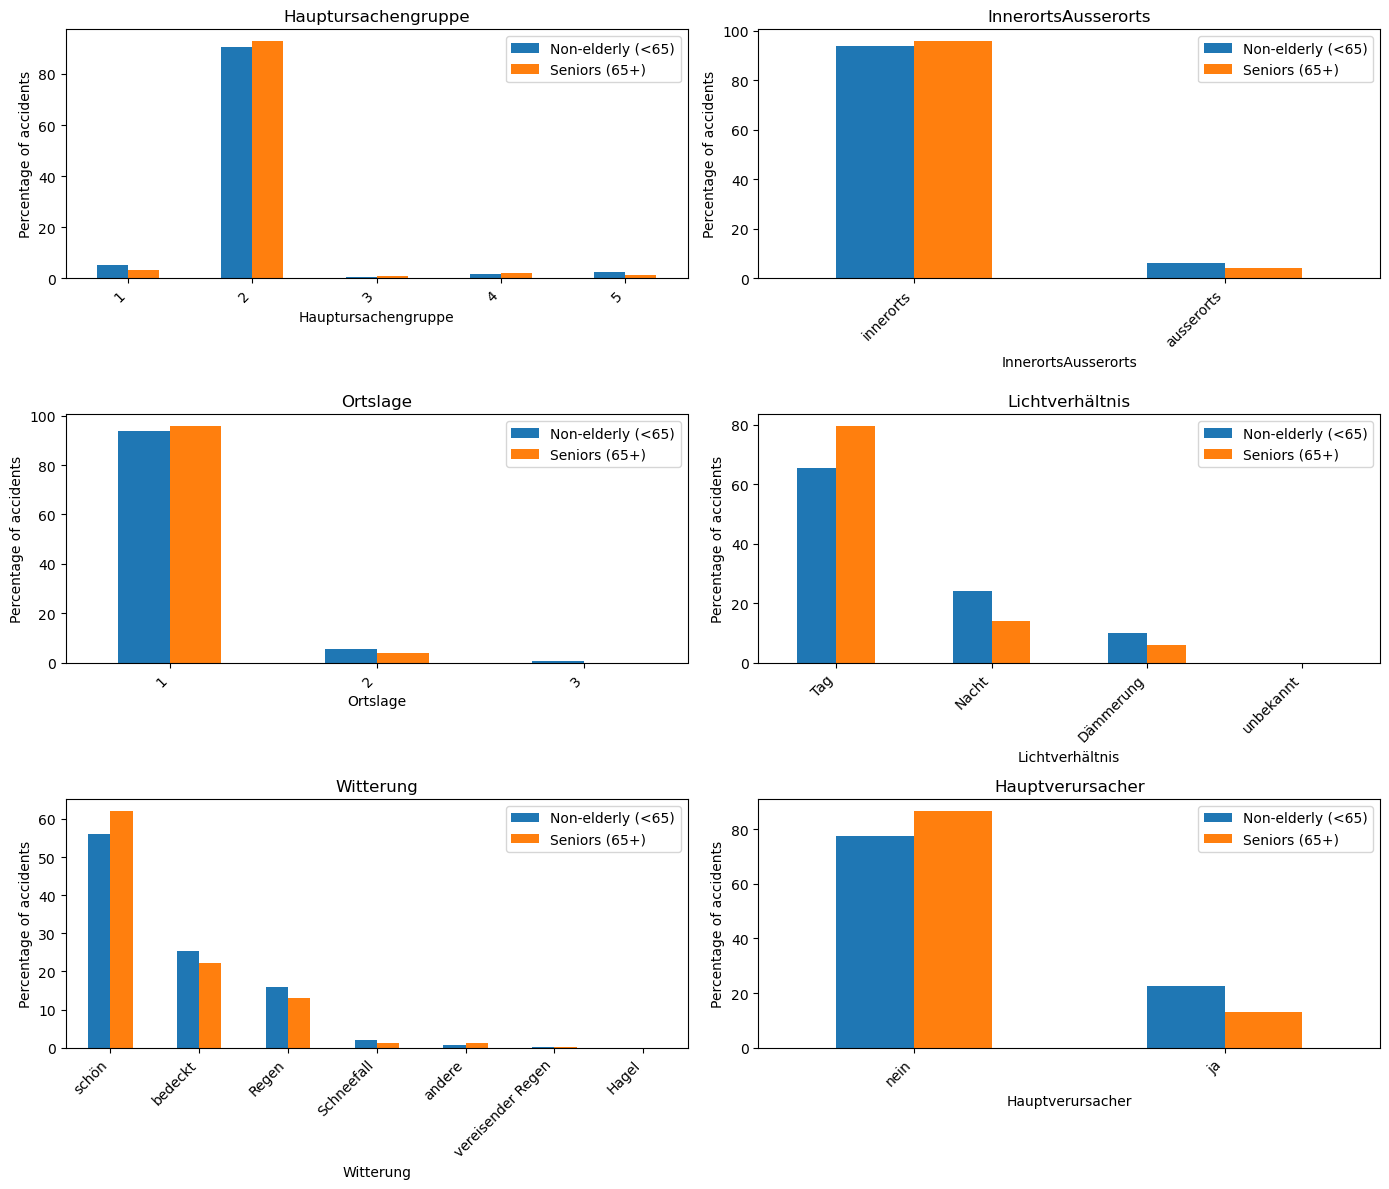

In [18]:
columns_to_analyze = ['Hauptursachengruppe', 
                      'InnerortsAusserorts', 'Ortslage', 'Lichtverhältnis', 'Witterung', 'Hauptverursacher']

n_cols = 2
n_rows = (len(columns_to_analyze) + 1) // n_cols  # ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows*4))
axes = axes.flatten()  # Flatten in case n_rows > 1

for i, col in enumerate(columns_to_analyze):
    ax = axes[i]
    
    # Compute percentages
    non_elderly_counts = df_1[df_1['Alter'] < 65][col].value_counts(normalize=True) * 100
    senior_counts = df_1[df_1['Alter'] >= 65][col].value_counts(normalize=True) * 100
    
    combined = pd.DataFrame({'Non-elderly (<65)': non_elderly_counts, 'Seniors (65+)': senior_counts}).fillna(0)
    
    combined.plot(kind='bar', ax=ax)
    ax.set_title(col)
    ax.set_ylabel('Percentage of accidents')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Remove any empty subplots if number of columns is odd
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()